# Template Match 1623
Classifier Emulation

In [1]:
#@title Connect to mass storage:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Load Python libraries:
!pip install filetype
import os
from   pathlib import Path
from   google.colab import files
import filetype
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title Setting base directories:
content_root = '/content/drive/MyDrive/'

classifier_dir = content_root + '/Classifiers/'

project_root = content_root + '/Template Match/'
targets_dir = project_root + 'Targets/'
templates_dir = project_root + 'Templates/'

In [4]:
#@title To check existance of objects:

def obj_exists(name,obj=None):
 if obj is None: return locals().has_key(name)
 else: return hasattr(obj,name)

def image_valid(image_path):

  if filetype.is_image(image_path):
    return True
  else:
    print(f"{image_path} is a not a valid image...")
    return False
  

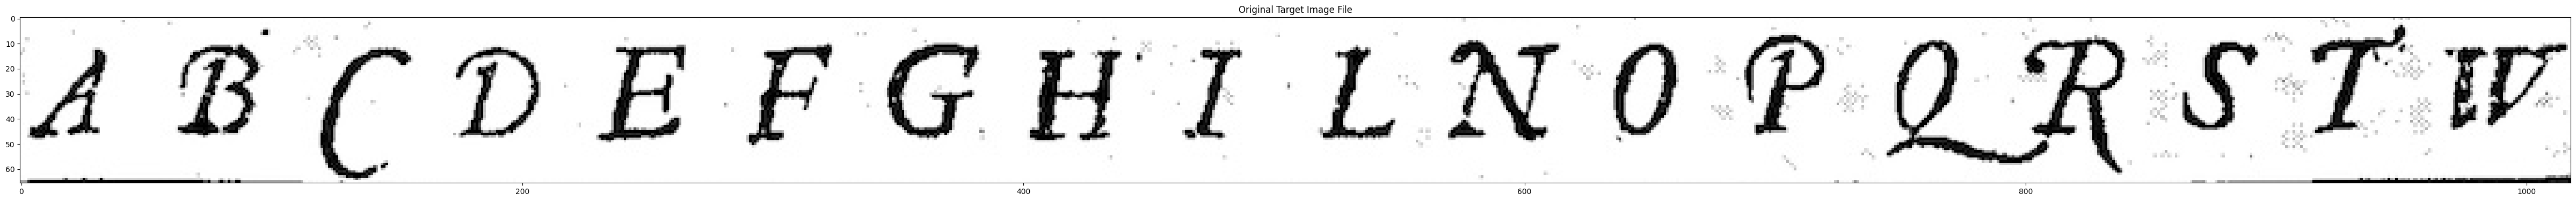

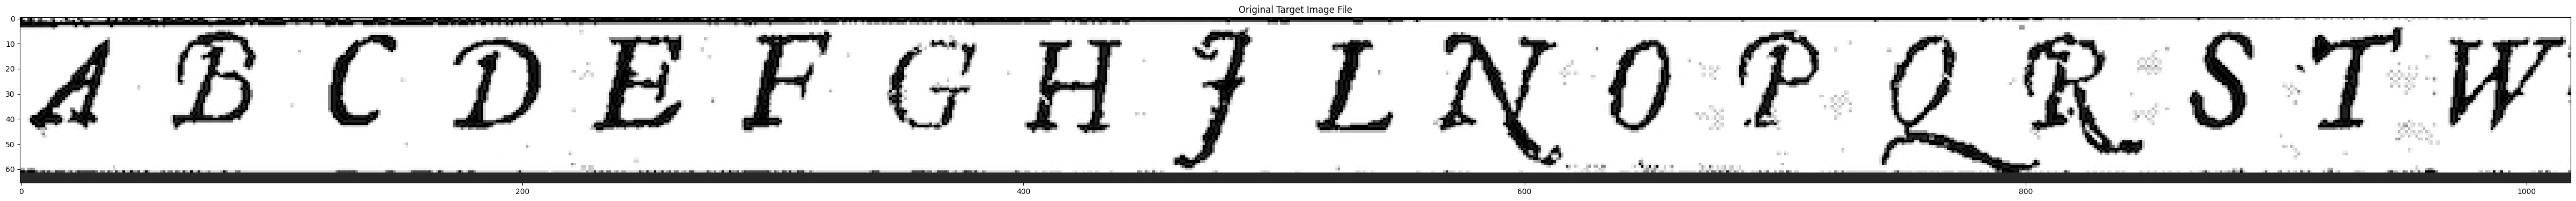

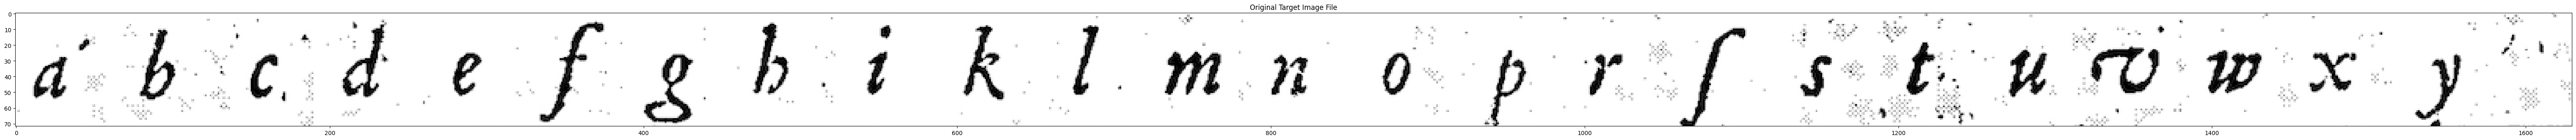

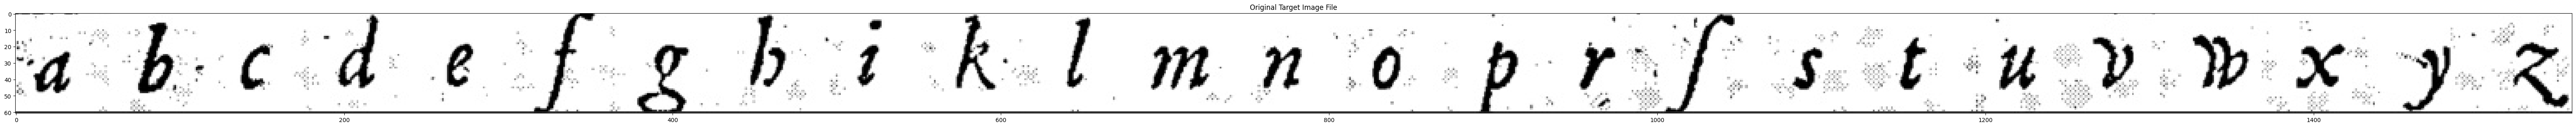

In [16]:
#@title Display Riverbank Laboratories classifier images:

classifiers = {
  'uc 0': classifier_dir + 'uc 0.jpg',
  'uc 1': classifier_dir + 'uc 1.jpg',
  'lc 0': classifier_dir + 'lc 0.jpg',
  'lc 1': classifier_dir + 'lc 1.jpg'
}

for cfp in classifiers.values():
  classifier_file_path = cfp

  if(image_valid(classifier_file_path)):

    classifier_image = cv2.imread(classifier_file_path)

    fig = plt.figure(figsize=(80,4))
    plt.title('Original Target Image File')
    plt.imshow(cv2.cvtColor(classifier_image, cv2.COLOR_BGR2RGB))
    plt.show()


In [6]:
#@title To Filter out duplicate bounding boxes:

def remove_duplicate_bounding_boxes(unfiltered_points):

  x = unfiltered_points[0]
  y = unfiltered_points[1]

  x_filter = []
  i = 0
  prev_x = 0
    
  while i < len(x):
      diff_x = x[i] - prev_x

      if(i == 0):
        x_filter.append(True)
      else:
        if diff_x < 10:
          x_filter.append(False)

        else:
          x_filter.append(True)

      prev_x = x[i]
      i += 1

  x_filtered = x[x_filter]
  y_filtered = y[x_filter]

  filtered_points = (x_filtered, y_filtered)
  return filtered_points

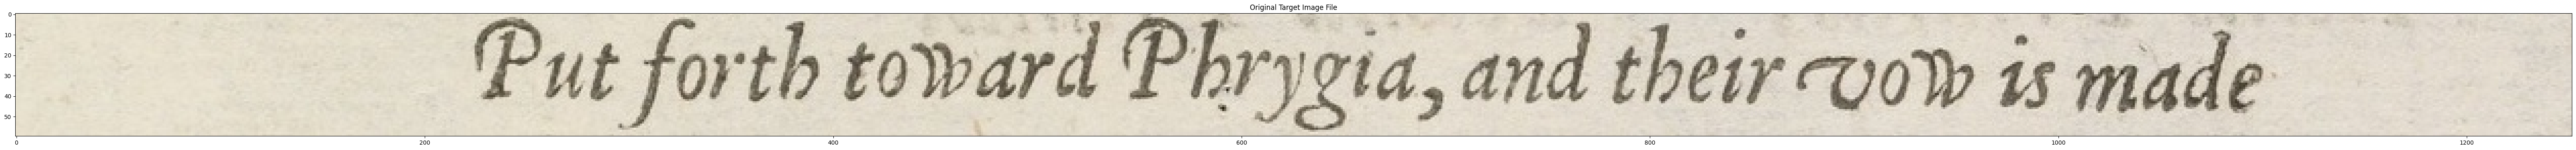

In [7]:
#@title Read and Display Target (larger) Image file:

# target_file_path ='/content/drive/MyDrive/Template Match/Targets/Bodlein TC Prologue 1623.jpg'
target_file_path ='/content/drive/MyDrive/Template Match/Targets/Prologue Line 7.jpg'

if(image_valid(target_file_path)):

  target_image = cv2.imread(target_file_path)

  fig = plt.figure(figsize=(80,4))
  plt.title('Original Target Image File')
  plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
  plt.show()

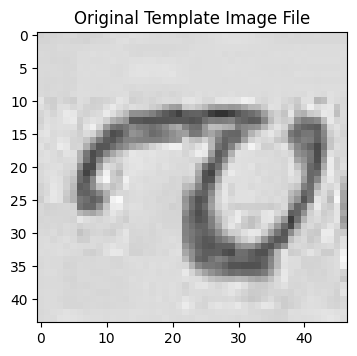

In [8]:
#@title Read and Display Template (smaller) Image file:

template_file_path = '/content/drive/MyDrive/Template Match/P-0.jpg'
template_file_path = '/content/drive/MyDrive/Classifiers/rb templet/lower case/a/o.jpg'
template_file_path = '/content/drive/MyDrive/Template Match/Templates/v.jpg'

if(image_valid(template_file_path)):

  template_image = cv2.imread(template_file_path, 0)

  fig = plt.figure(figsize=(4,4))
  plt.title('Original Template Image File')
  plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [9]:
#@title Preprocess the Target image data:
target_gray = cv2.cvtColor(target_image,cv2.COLOR_BGR2GRAY)
target_blur = cv2.GaussianBlur(target_gray, (5,5), 0)
target_thresh = cv2.threshold(target_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
target_dilate = cv2.dilate(target_thresh, kernel, iterations=2)

# Find contours, obtain bounding box coordinates, and extract ROI:
cnts = cv2.findContours(target_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

In [10]:
#@title Apply the template matching onto the Target from the Template:
# Remember, that the size of the template should 
# be as much as possible the same, as its size in the target image.

res = cv2.matchTemplate(target_gray,
                        template_image,
                        cv2.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res) 


In [11]:
#@title Set threshold for multiple occurrences:

threshold = 0.70
unfiltered_points = np.where(res >= threshold) 

In [12]:
#@title Display unfiltered points in a Dataframe:
dr = pd.DataFrame(unfiltered_points)
dr_transposed = dr.T # or df2.transpose()
dr_transposed.columns =['x', 'y']

styles = [dict(selector="caption",
                props=[
                        ("text-align", "center"),
                        ("font-size", "150%"),
                        ("color", 'orange')
                      ]
              )
          ]

dr_transposed = dr_transposed.style.set_caption("Unfiltered Center Points").set_table_styles(styles)

dr_transposed


,x,y
0,9,866
1,9,867
2,9,868
3,10,866
4,10,867
5,10,868
6,11,866
7,11,867
8,11,868


In [13]:
#@title Display Filtered points in Dataframe:

filtered_points = remove_duplicate_bounding_boxes(unfiltered_points)

dr = pd.DataFrame(filtered_points)
dr_transposed = dr.transpose()
dr_transposed.columns =['x', 'y']

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'orange')])]
dr_transposed.style.set_caption("caption set").set_table_styles(styles)
dr_transposed.index = dr_transposed.index + 1
dr_transposed.style.set_table_attributes("style='display:inline'").set_caption('Caption table')
dr_transposed =  dr_transposed.style.set_caption("Filtered Center Points").set_table_styles(styles)

dr_transposed

,x,y
1,9,866


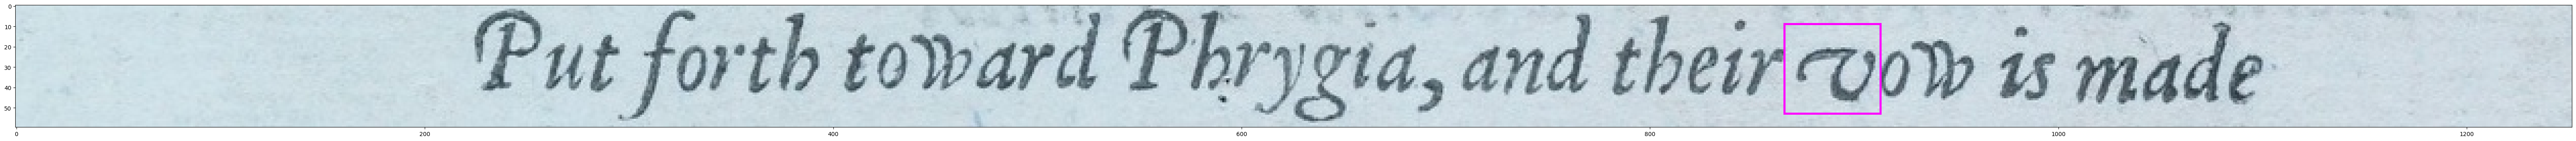

In [17]:
#@title "Draw rectangles on the Target which match the Template at or above the Threshold:"

w, h = template_image.shape[::-1]

confidence_loc_list = []
for pt in zip(*filtered_points[::-1]):
    cv2.rectangle(target_image, pt, (pt[0] + w, pt[1] + h), (255,0,255), 1)
    confidence = res[pt[1]][pt[0]]
    confidence_loc_list.append(confidence)

fig = plt.figure(figsize=(80,60))
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.imshow(target_image)
plt.show()


In [15]:
#@title Display Confidence of filtered points in Dataframe:

dff = pd.DataFrame(confidence_loc_list, columns =['Center points'], dtype = float) 

dff.index = dff.index + 1

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'orange')])]

dff =  dff.style.set_caption("Confidence").set_table_styles(styles)
dff


,Center points
1,0.708645
